In [1]:
import logging
from logging.handlers import RotatingFileHandler
import pandas_gbq
from google.cloud import bigquery
import os
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from dotenv import load_dotenv
load_dotenv()
rs = 30
logfile = 'chicago.log'
handler = RotatingFileHandler(logfile, 
    maxBytes=5*1024*1024,
    mode='a', 
    backupCount=2,
    encoding=None,
    delay=0)

logging.basicConfig(format='%(asctime)s %(levelname)s %(filename)s %(lineno)d:%(message)s',
    datefmt='%Y/%m/%d %H:%M:%S ',
    handlers = [handler],
    level=logging.INFO)

# Data Extraction

This data extraction is only limited to 10,000 rows because I don't want to hit GCP limit

In [2]:
sql = """
SELECT * FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` LIMIT 10000
"""
df = pandas_gbq.read_gbq(sql, project_id=os.environ.get("PROJECT_ID"))
df_orig = df.copy()

Downloading: 100%|██████████| 10000/10000 [00:03<00:00, 2557.31rows/s]


# Data Exploration Seconds, Miles and Fares

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              10000 non-null  object             
 1   taxi_id                 10000 non-null  object             
 2   trip_start_timestamp    10000 non-null  datetime64[ns, UTC]
 3   trip_end_timestamp      9999 non-null   datetime64[ns, UTC]
 4   trip_seconds            9997 non-null   float64            
 5   trip_miles              10000 non-null  float64            
 6   pickup_census_tract     1912 non-null   float64            
 7   dropoff_census_tract    1791 non-null   float64            
 8   pickup_community_area   10000 non-null  int64              
 9   dropoff_community_area  9640 non-null   float64            
 10  fare                    9999 non-null   float64            
 11  tips                    9999 non-null   fl

In [4]:
df.describe()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,9997.000000,10000.000000,1.912000e+03,1.791000e+03,10000.000000,9640.000000,9999.000000,9999.000000,9995.000000,9999.000000,9999.000000,10000.000000,10000.000000,9642.000000,9642.000000
mean,768.001600,2.184315,1.703145e+10,1.703145e+10,17.479700,23.893568,13.139921,0.887340,0.006793,1.664023,15.698125,41.913570,-87.649626,41.912126,-87.664499
std,947.296857,5.276077,2.282536e+05,2.395271e+05,15.828994,21.129254,15.113502,2.166725,0.641344,54.829604,56.964660,0.072038,0.042717,0.064448,0.060854
min,0.000000,0.000000,1.703105e+10,1.703103e+10,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.660136,-87.759857,41.660136,-87.913625
25%,180.000000,0.000000,1.703133e+10,1.703133e+10,3.000000,6.000000,5.250000,0.000000,0.000000,0.000000,5.750000,41.859350,-87.655879,41.859350,-87.687516
50%,540.000000,0.400000,1.703133e+10,1.703133e+10,14.000000,21.000000,8.750000,0.000000,0.000000,0.000000,10.000000,41.965812,-87.655879,41.942859,-87.655879
75%,1080.000000,2.400000,1.703183e+10,1.703183e+10,33.000000,33.000000,18.000000,0.000000,0.000000,0.000000,19.500000,41.965812,-87.617358,41.965812,-87.625192
max,30480.000000,332.200000,1.703183e+10,1.703198e+10,54.000000,77.000000,805.200000,40.500000,64.000000,3431.940000,3435.190000,41.970289,-87.534903,42.009623,-87.534903


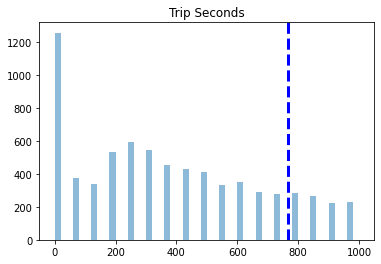

In [5]:
plt.title("Trip Seconds")
plt.hist(df['trip_seconds'], bins=50, alpha=0.5,range=[0,1000])
plt.axvline(df['trip_seconds'].mean(), color='b', linestyle='dashed', linewidth=3)
plt.show()

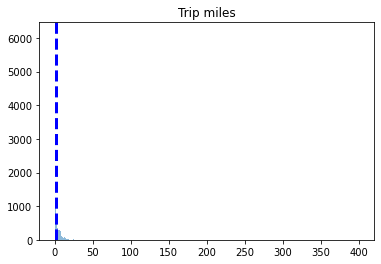

In [6]:
plt.title("Trip miles")
plt.hist(df['trip_miles'], bins=400, alpha=0.5,range=[0,400])
plt.axvline(df['trip_miles'].mean(), color='b', linestyle='dashed', linewidth=3)
plt.show()

Data at 0 seconds and at trip miles is a bit strange, it does not make sense to have a trip that the duration is 0 and/orthe miles are 0 as well. Same problem for Data with a Trip in second that is too big biger than 75% std

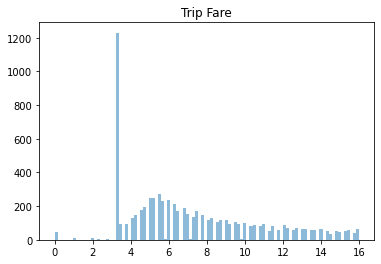

In [7]:
plt.title("Trip Fare")
plt.hist(df['fare'], bins=100, alpha=0.5,range=[0,16])
#plt.axvline(df['fare'].mean(), color='b', linestyle='dashed', linewidth=3)
plt.show()

Trips with a fare bigger than 16 is already outside the 75% of the std so this is cleaned up as well. Also fares which are 0. I will filter first all the outliers outside the 75% std. Removing all the trips that the cost is 0

In [8]:
mask = (df['trip_seconds'] > 0) & (df['trip_miles'] > 0) &   (df['fare'] > 0)  & (df['trip_seconds'] < 1000) & (df['trip_miles'] < 400) & (df['fare'] < 16) & (df['trip_total']>0)
# Cleanining up all with a fare of 0, and a 
filtered_df = df.loc[mask]

# Exploring data generation

I'll try to predict the locations based on the time, miles and fare. Based on my exploration I only find that all the locations are available if one of them is available.

In [9]:
filtered_df.describe()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,3400.000000,3400.000000,5.470000e+02,5.290000e+02,3400.000000,3355.000000,3400.000000,3400.000000,3400.0,3400.000000,3400.000000,3400.000000,3400.000000,3355.000000,3355.000000
mean,458.294118,1.583485,1.703132e+10,1.703132e+10,14.646176,21.102832,8.139056,0.505638,0.0,0.353624,8.998465,41.924346,-87.650059,41.921918,-87.654778
std,238.119351,6.027525,7.248912e+04,7.787238e+04,15.127733,21.590524,2.997183,1.132949,0.0,1.888692,3.869028,0.066070,0.037357,0.066045,0.039153
min,60.000000,0.050000,1.703105e+10,1.703103e+10,3.000000,1.000000,3.250000,0.000000,0.0,0.000000,3.250000,41.728182,-87.759857,41.729676,-87.806020
25%,240.000000,0.500000,1.703133e+10,1.703133e+10,3.000000,4.000000,5.750000,0.000000,0.0,0.000000,6.250000,41.859350,-87.655879,41.859350,-87.670167
50%,420.000000,1.100000,1.703133e+10,1.703133e+10,3.000000,12.000000,7.500000,0.000000,0.0,0.000000,8.500000,41.965812,-87.655879,41.944227,-87.655879
75%,660.000000,2.100000,1.703133e+10,1.703133e+10,33.000000,33.000000,10.050000,0.000000,0.0,0.000000,11.000000,41.965812,-87.617358,41.968069,-87.617860
max,960.000000,332.200000,1.703183e+10,1.703183e+10,47.000000,77.000000,15.750000,18.300000,0.0,56.000000,79.300000,41.970289,-87.551428,42.009623,-87.551428


In [10]:
filtered_df.loc[~filtered_df['dropoff_census_tract'].isnull()].corr()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
trip_seconds,1.000000,0.619802,-0.037870,-0.185189,0.019125,-0.179931,0.899721,0.128827,NaN,-0.076844,0.462772,-0.032252,0.042496,0.143922,-0.235032
trip_miles,0.619802,1.000000,-0.114942,-0.217159,-0.043424,-0.176440,0.739521,0.146856,NaN,-0.069623,0.386960,0.015989,0.013618,0.120514,-0.168357
pickup_census_tract,-0.037870,-0.114942,1.000000,0.924157,0.587097,0.477912,-0.046044,-0.074628,NaN,0.000865,-0.044683,-0.396205,-0.098252,-0.351183,-0.032491
dropoff_census_tract,-0.185189,-0.217159,0.924157,1.000000,0.523967,0.611806,-0.212472,-0.103257,NaN,0.010316,-0.135082,-0.339908,-0.114169,-0.442593,0.060293
pickup_community_area,0.019125,-0.043424,0.587097,0.523967,1.000000,0.866345,-0.018974,-0.033685,NaN,0.024873,-0.001345,-0.972127,0.676686,-0.869637,0.535120
dropoff_community_area,-0.179931,-0.176440,0.477912,0.611806,0.866345,1.000000,-0.247214,-0.070561,NaN,0.035595,-0.126293,-0.843711,0.606398,-0.932680,0.604540
fare,0.899721,0.739521,-0.046044,-0.212472,-0.018974,-0.247214,1.000000,0.147363,NaN,-0.087492,0.513984,0.007590,-0.001172,0.178357,-0.242220
tips,0.128827,0.146856,-0.074628,-0.103257,-0.033685,-0.070561,0.147363,1.000000,NaN,0.319710,0.588073,0.014910,0.039109,0.036428,0.006859
tolls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extras,-0.076844,-0.069623,0.000865,0.010316,0.024873,0.035595,-0.087492,0.319710,NaN,1.000000,0.770360,-0.028387,0.031777,-0.037566,0.041320


At a quick look there's no correlation between the fares and the pickup locations and drop off locations. The Correlation between Fare and Dropoff community might be used in the future to generate the data.

Using the sample function will be the easiest way to populate missing data with some values to have something instead of NaN

In [11]:
data_generator = filtered_df.loc[~filtered_df['dropoff_census_tract'].isnull()]

In [12]:
df.describe()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,9997.000000,10000.000000,1.912000e+03,1.791000e+03,10000.000000,9640.000000,9999.000000,9999.000000,9995.000000,9999.000000,9999.000000,10000.000000,10000.000000,9642.000000,9642.000000
mean,768.001600,2.184315,1.703145e+10,1.703145e+10,17.479700,23.893568,13.139921,0.887340,0.006793,1.664023,15.698125,41.913570,-87.649626,41.912126,-87.664499
std,947.296857,5.276077,2.282536e+05,2.395271e+05,15.828994,21.129254,15.113502,2.166725,0.641344,54.829604,56.964660,0.072038,0.042717,0.064448,0.060854
min,0.000000,0.000000,1.703105e+10,1.703103e+10,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.660136,-87.759857,41.660136,-87.913625
25%,180.000000,0.000000,1.703133e+10,1.703133e+10,3.000000,6.000000,5.250000,0.000000,0.000000,0.000000,5.750000,41.859350,-87.655879,41.859350,-87.687516
50%,540.000000,0.400000,1.703133e+10,1.703133e+10,14.000000,21.000000,8.750000,0.000000,0.000000,0.000000,10.000000,41.965812,-87.655879,41.942859,-87.655879
75%,1080.000000,2.400000,1.703183e+10,1.703183e+10,33.000000,33.000000,18.000000,0.000000,0.000000,0.000000,19.500000,41.965812,-87.617358,41.965812,-87.625192
max,30480.000000,332.200000,1.703183e+10,1.703198e+10,54.000000,77.000000,805.200000,40.500000,64.000000,3431.940000,3435.190000,41.970289,-87.534903,42.009623,-87.534903


A better way to fill the empty ones can be used. A way it is to use the data_generator and use the sample function using a lambda expresion that returns a different sample according to the data_generator distribution. Since the mean comes from the dataset where the data is populated then if the populating process runs a couple of times the result is that the mean will not deviate a lot and the filling of the data might be useless depending on the needs

In [13]:
df['pickup_community_area'] = df['pickup_community_area'].fillna(data_generator['pickup_community_area'].mean())
df['dropoff_census_tract'] = df['dropoff_census_tract'].fillna(data_generator['dropoff_census_tract'].mean())
df['pickup_community_area'] = df['pickup_community_area'].fillna(data_generator['pickup_community_area'].mean())
df['dropoff_community_area'] = df['dropoff_community_area'].fillna(data_generator['dropoff_community_area'].mean())
df['pickup_latitude'] = df['pickup_latitude'].fillna(data_generator['pickup_latitude'].mean())
df['pickup_longitude'] = df['pickup_longitude'].fillna(data_generator['pickup_longitude'].mean())
df['dropoff_latitude'] = df['dropoff_latitude'].fillna(data_generator['dropoff_latitude'].mean())
df['dropoff_longitude'] = df['dropoff_longitude'].fillna(data_generator['dropoff_longitude'].mean())

In [14]:
df.describe()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,9997.000000,10000.000000,1.912000e+03,1.000000e+04,10000.000000,10000.000000,9999.000000,9999.000000,9995.000000,9999.000000,9999.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,768.001600,2.184315,1.703145e+10,1.703134e+10,17.479700,24.149604,13.139921,0.887340,0.006793,1.664023,15.698125,41.913570,-87.649626,41.910470,-87.662989
std,947.296857,5.276077,2.282536e+05,1.143527e+05,15.828994,20.787672,15.113502,2.166725,0.641344,54.829604,56.964660,0.072038,0.042717,0.063865,0.060267
min,0.000000,0.000000,1.703105e+10,1.703103e+10,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.660136,-87.759857,41.660136,-87.913625
25%,180.000000,0.000000,1.703133e+10,1.703132e+10,3.000000,6.000000,5.250000,0.000000,0.000000,0.000000,5.750000,41.859350,-87.655879,41.859350,-87.683835
50%,540.000000,0.400000,1.703133e+10,1.703132e+10,14.000000,21.000000,8.750000,0.000000,0.000000,0.000000,10.000000,41.965812,-87.655879,41.922761,-87.655879
75%,1080.000000,2.400000,1.703183e+10,1.703132e+10,33.000000,33.000000,18.000000,0.000000,0.000000,0.000000,19.500000,41.965812,-87.617358,41.965812,-87.622314
max,30480.000000,332.200000,1.703183e+10,1.703198e+10,54.000000,77.000000,805.200000,40.500000,64.000000,3431.940000,3435.190000,41.970289,-87.534903,42.009623,-87.534903


# Generating Data with Samples to follow distributions

In [15]:
df_generated = df_orig.copy()
df_generated.isna().any() # Checking which points are needed to fill in

unique_key                False
taxi_id                   False
trip_start_timestamp      False
trip_end_timestamp         True
trip_seconds               True
trip_miles                False
pickup_census_tract        True
dropoff_census_tract       True
pickup_community_area     False
dropoff_community_area     True
fare                       True
tips                       True
tolls                      True
extras                     True
trip_total                 True
payment_type              False
company                    True
pickup_latitude           False
pickup_longitude          False
pickup_location           False
dropoff_latitude           True
dropoff_longitude          True
dropoff_location           True
dtype: bool

In [16]:
# Setting to 0 all Nans since Apply does not work with Nans
# We use the df_orig instead of df_generated to generate random data points since df_generated has a probability of returning a 0 since the value is available there
column = 'dropoff_latitude'
df_generated[column] = df_generated[column].fillna(0)
df_generated[column] =df_generated[column].apply(lambda x: df_orig.loc[~df_orig[column].isnull()][column].sample(1).item() if x == 0 else x)
column = 'dropoff_longitude'
df_generated[column] = df_generated[column].fillna(0)
df_generated[column] =df_generated[column].apply(lambda x: df_orig.loc[~df_orig[column].isnull()][column].sample(1).item() if x == 0 else x)

Lambda function to generate dropoff location is differen since it requires two columsn and a concat of strings. eg "POINT (-87.642648998 41.8792550844)"

In [17]:
df_generated['dropoff_location'] = df_generated['dropoff_location'].fillna(0)
df_generated['dropoff_location'] = df_generated.apply(lambda x: 'POINT ('+str(x['dropoff_longitude'])+' '+str(x['dropoff_latitude'])+ ')' if x['dropoff_location'] ==0 else x['dropoff_location'], axis=1)

In [18]:
df_generated['company'] = df_generated['company'].fillna('CompanyNotAssigned')

# Generate the end timestamp

The timestamp is going to work differently since the end time needs to match the end timestamp and the end time needs to be bigger than the start time. It is easier to generate the trip in seconds first and then add the seconds to the star ttime to calculate the end timestamp. The trip in miles needs to make sense to the trip in seconds

The problem with the timestamp is that it depends on the trip on seconds, this seconds depnds on the miles ( which is not null). These miles need to make sense from a random generated lattitude and longitued. The generation of this feature is dependant on the rest which makes it more complex to accurately generate one

A simple approach is to take the trip in miles and fare and use a linear regression assuming there's a correlation between these three.

In [19]:
df_model = df_generated.loc[~df_generated['trip_seconds'].isnull() & ~df_generated['trip_miles'].isnull()].copy()
#df_model = df_model[['trip_miles','trip_seconds','fare']]

In [20]:
df_model = df_model.loc[df_model['trip_miles']>0]
df_model = df_model.loc[df_model['trip_miles']<4]
df_model = df_model.loc[df_model['trip_seconds']<=18000]
df_model = df_model.loc[df_model['fare']<=50]
df_model = df_model.loc[df_model['fare']>0]

In [21]:
df_model.describe()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,4163.000000,4163.000000,6.270000e+02,5.990000e+02,4163.000000,4085.000000,4163.000000,4163.000000,4163.0,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,671.688686,1.153128,1.703133e+10,1.703132e+10,15.643767,22.617870,10.745097,0.709186,0.0,0.387668,11.842071,41.919729,-87.648855,41.917557,-87.659594
std,576.995572,1.004657,8.513671e+04,1.062381e+05,15.616520,21.873414,7.247369,1.578789,0.0,2.018478,8.223535,0.069515,0.039197,0.066221,0.051604
min,0.000000,0.050000,1.703106e+10,1.703103e+10,3.000000,1.000000,3.250000,0.000000,0.0,0.000000,3.250000,41.728182,-87.759857,41.690633,-87.913625
25%,300.000000,0.400000,1.703133e+10,1.703133e+10,3.000000,6.000000,6.000000,0.000000,0.0,0.000000,6.500000,41.859350,-87.655879,41.859350,-87.670167
50%,540.000000,0.900000,1.703133e+10,1.703133e+10,3.000000,14.000000,8.500000,0.000000,0.0,0.000000,9.500000,41.965812,-87.655879,41.944227,-87.655879
75%,840.000000,1.700000,1.703133e+10,1.703133e+10,33.000000,33.000000,12.250000,0.000000,0.0,0.000000,13.500000,41.965812,-87.617358,41.965812,-87.625192
max,8340.000000,3.900000,1.703183e+10,1.703198e+10,47.000000,77.000000,49.750000,18.300000,0.0,56.000000,79.300000,41.970289,-87.551428,42.009623,-87.551428


In [22]:
df_model.corr()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
trip_seconds,1.000000,-0.002097,-0.099707,-0.109579,0.063023,0.122282,0.881836,0.237408,NaN,-0.026619,0.816197,-0.080386,0.029074,-0.074562,-0.283326
trip_miles,-0.002097,1.000000,-0.002040,-0.127897,-0.037851,-0.035574,-0.052680,-0.041952,NaN,-0.028259,-0.061411,0.053286,-0.067744,0.079966,-0.024338
pickup_census_tract,-0.099707,-0.002040,1.000000,0.488916,0.458956,0.083922,-0.128090,-0.017730,NaN,0.000169,-0.092648,-0.258840,-0.004395,-0.177330,0.105203
dropoff_census_tract,-0.109579,-0.127897,0.488916,1.000000,0.131771,0.672989,-0.001381,-0.127837,NaN,-0.005179,-0.037662,0.068001,-0.375978,0.035136,-0.514866
pickup_community_area,0.063023,-0.037851,0.458956,0.131771,1.000000,0.384629,0.070733,0.077321,NaN,0.053988,0.090420,-0.962547,0.631688,-0.819457,0.438170
dropoff_community_area,0.122282,-0.035574,0.083922,0.672989,0.384629,1.000000,0.165332,0.081621,NaN,0.014830,0.166417,-0.401205,0.328895,-0.362178,0.014075
fare,0.881836,-0.052680,-0.128090,-0.001381,0.070733,0.165332,1.000000,0.339693,NaN,-0.011190,0.943759,-0.091882,0.032760,-0.091009,-0.339865
tips,0.237408,-0.041952,-0.017730,-0.127837,0.077321,0.081621,0.339693,1.000000,NaN,0.171005,0.533330,-0.085645,0.091587,-0.049394,-0.109983
tolls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extras,-0.026619,-0.028259,0.000169,-0.005179,0.053988,0.014830,-0.011190,0.171005,NaN,1.000000,0.268417,-0.036102,0.018754,-0.038401,0.016122


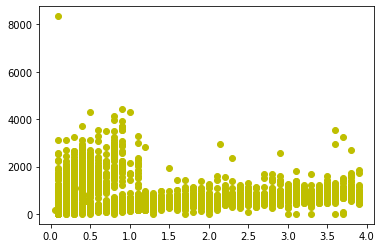

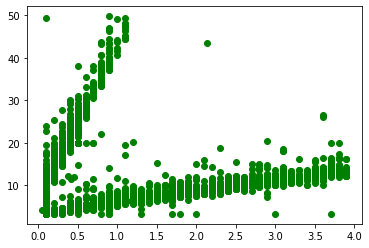

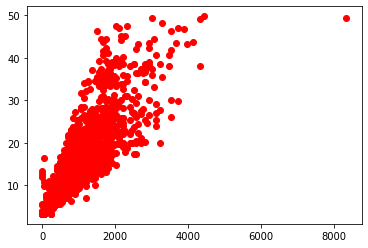

In [23]:
plt.scatter(df_model['trip_miles'], df_model['trip_seconds'],  color='y')
plt.show()
plt.scatter(df_model['trip_miles'], df_model['fare'],  color='g')
plt.show()
plt.scatter(df_model['trip_seconds'], df_model['fare'],  color='r')
plt.show()

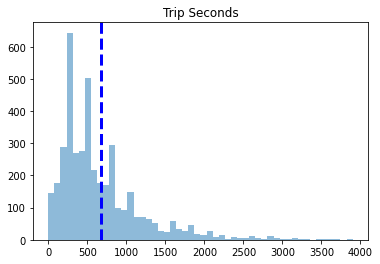

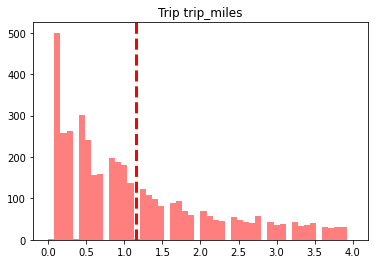

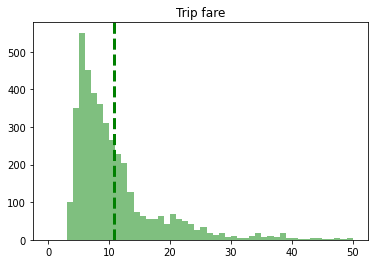

In [24]:
plt.title("Trip Seconds")
plt.hist(df_model['trip_seconds'], bins=50, alpha=0.5,range=[0,3900])
plt.axvline(df_model['trip_seconds'].mean(), color='b', linestyle='dashed', linewidth=3)
plt.show()
plt.title("Trip trip_miles")
plt.hist(df_model['trip_miles'], bins=50, alpha=0.5,range=[0,4], color = 'r')
plt.axvline(df_model['trip_miles'].mean(), color='r', linestyle='dashed', linewidth=3)
plt.show()
plt.title("Trip fare")
plt.hist(df_model['fare'], bins=50, alpha=0.5,range=[0,50], color = 'g')
plt.axvline(df_model['fare'].mean(), color='g', linestyle='dashed', linewidth=3)
plt.show()

Normalizing should only be done if needed for our data for a multivariate regresion. Units might stop making sense now since the normalization. This type of data does not require a normalization.

In [25]:
#from sklearn.preprocessing import scale,StandardScaler
#scaler_fare = StandardScaler().fit(df_model['fare'].values.reshape(-1, 1) )
#df_model['fare'] = scale(df_model['fare'])
#scaler_miles = StandardScaler().fit(df_model['trip_miles'].values.reshape(-1, 1) )
#df_model['trip_miles'] = scale(df_model['trip_miles'])
#scaler_seconds = StandardScaler().fit(df_model['trip_seconds'].values.reshape(-1, 1) )
#df_model['trip_seconds'] = scale(df_model['trip_seconds'])
## use scale_model.inverse_transform() to denormalize

In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression
x = df_model['trip_miles'].values.reshape(-1,1)
y = df_model[['trip_seconds','fare']].values
model = LinearRegression()
model.fit(x, y)
print('slope:', model.coef_)
#print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)

slope: [[-1.2042746]
 [-0.3800249]]
intercept: [673.07736827  11.18331447]
